In [1]:
import numpy as np
import random
import copy
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
#     Sequence:
# 0 - charged
# 1 - polar
# 2 - hydrophobc

#energy parameter for side chain interaction
sc = 0.7

# side chain interaction array
CharacterArray = [[sc,      0.25*sc,     0],
                  [0.25*sc, 0.5*sc,      0],
                  [0,       0,     0.25*sc]]

#hydrogen bond parameter
HBparam = 0.2

#Flatness ratio
FlatRatio = 0.98

F_ENTER = [True]

CHECK_FREQ = 1e5
CHECK_START = 1e6

# Wang-Landau acceptance criterion
def WLchoice(enew):
    eold = Energy_list[-1]
    if enew not in lng.keys():
        return True
    
    delta = lng[eold]-lng[enew]
    
    if delta >= 0:
        return True
    else:
        rn = random.random()
        if rn <= np.exp(delta):
            return True
        else:
            return False
        

def buildNeighbourList(chain_coords,rid):
    x,y,z = [pos for pos in chain_coords[rid]]
    
    neighbours = []
    for xn in (x-1,x,x+1):
        for yn in (y-1,y,y+1):
            for zn in (z-1,z,z+1):
                if [xn,yn,zn] in chain_coords and [xn,yn,zn] != [x,y,z] and ((abs(xn-x)+abs(yn-y)+abs(zn-z)) == 2):
                    tindex = chain_coords.index([xn,yn,zn])
                    if tindex != rid-1 and tindex != rid+1:
                        neighbours.append(tindex)      
    return neighbours



# This can be run in parallel - the side-chains interactions
# Not the hydrogen bonds
def getEnergy(chain_coords,sequence):
    
    character_e = 0
    HBe = 0
    
    #iterate over each residue in the chain
    #calculate separate contributions of the energy
    #character, H-bonds, chain stiffness
    #!!!Avoid double-counting
    
    for res_id in range(len(chain_coords)):
        resc = sequence[res_id]
        neighbour_list = buildNeighbourList(chain_coords,res_id)
        
        #remove nearest neighbours
        for icheck in neighbour_list:
            if icheck in [res_id-1,res_id,res_id+1]:
                ind = neighbour_list.index(icheck)
                neighbour_list.pop(ind)
        #print(len(neighbour_list))
        for neigh in neighbour_list:
            neighc = sequence[neigh]
            character_e += CharacterArray[resc][neighc]
                
        if (CanHBond[res_id]):       
            for icheck in neighbour_list:
                if abs(icheck - res_id) < 4 or not CanHBond[icheck]:
                    ind = neighbour_list.index(icheck)
                    neighbour_list.pop(ind)
        if len(neighbour_list) != 0:               
            randHbond = random.choice(neighbour_list)
            HBe += HBparam
            CanHBond[res_id] = False
            CanHBond[randHbond] = False
                
    return (-HBe-character_e/2)
        
        
    
def UpdateStats(accept,new_energy,res_id,chain_coords,new_coords,F_ENTER,Histogram,lng,Snaps):
    
    if(accept):
        #F_ENTER[0] = True
        chain_coords[res_id] = copy.deepcopy(new_coords)
        Configuration_list.append(copy.deepcopy(chain_coords))
        TotalMoves.append(1)
        AcceptedMoves.append(1)
        Energy_list.append(new_energy)
        
        if new_energy in Histogram.keys():
            Histogram[new_energy] += 1
        else:
            Histogram[new_energy] = 1
        
        if new_energy in lng.keys():
            lng[new_energy] += copy.deepcopy(lnf[0])
        else:
            lng[new_energy] = copy.deepcopy(lnf[0])
            
        MovePattern.append(1)
        
    else:
        MovePattern.append(0)
        eold = Energy_list[-1]
        TotalMoves.append(1)
        Energy_list.append(eold)
        if eold in Histogram.keys():
            Histogram[eold] += 1
        else:
            Histogram[eold] = 1
        
        if eold in lng.keys():
            lng[eold] += copy.deepcopy(lnf[0])
        else:
            lng[eold] = copy.deepcopy(lnf[0])
             
            
            
def FlatnessCheck(lnf,F_ENTER,Histogram,lng,Snaps):
    if(len(TotalMoves) >= CHECK_START and len(TotalMoves)%CHECK_FREQ == 0):# and F_ENTER[0]):
        
#         F_ENTER[0] = False
#         energybins = []
#         values = []
#         for k in sorted(Histogram.keys()):
#             energybins.append(k)
#             values.append(Histogram[k])
    
#         av = np.average(values)
#         count = 0
#         for i in values:
#             if i < (av+np.std(values)) and i > (av-np.std(values)):
#                 count +=1


        energybins = []
        values = []
        for k in sorted(Histogram.keys()):
            energybins.append(k)
            values.append(Histogram[k])
        count = 0
        for i in values:
            if i > np.log(2)/lnf[0]:
                count +=1
        print("#############################\n")
        print(f'Flatness ratio: {count/len(energybins)}\n\
        Number of moves: {len(TotalMoves)}\n\
        Accepted moves: {len(AcceptedMoves)}\n\
        Acceptance Ratio: {len(AcceptedMoves)/len(TotalMoves)}\n')
        if((count/len(energybins))>=FlatRatio):
            print(f"Reseting the histogram.\n\
            Current size: {len(Histogram)}\n\
            Min Energy {min(Histogram.keys())}\n\
            Max Energy {max(Histogram.keys())}\n\
            ")
            Snaps.append(copy.deepcopy(Histogram))
            Histogram = {}
            lnf[0] = copy.deepcopy(lnf[0])/2.0
            print("Updated ln(f) to: ",lnf[0]) 
            print("##########################\n\n")
            
            
def makeMove(chain_coords,sequence,lnf,F_ENTER,Histogram,lng,Snaps):
    
    #choose a random coordinate, add or substract 2, check connectivity
    #get new energy
    # accept or reject
    # return
    # run updates
    
    res_id = random.randint(1,len(chain_coords)-2)
    xyz = random.choice([0,1,2])
    new_coords = copy.deepcopy(chain_coords[res_id])
    new_coords[xyz] += random.choice([-2,2])
    
    x0,y0,z0 = [c for c in new_coords]
    a = True
    b = True
    if res_id !=0 and res_id != len(seq)-1:
        x1,y1,z1 = [c for c in chain_coords[res_id-1]]
        a = ((abs(x1-x0)+abs(y1-y0)+abs(z1-z0)) == 2  and ((abs(x1-x0) <= 1 and abs(y1-y0) <=1 and abs(z1-z0)) <= 1))  
        x2,y2,z2 = [c for c in chain_coords[res_id+1]]
        b = ((abs(x2-x0)+abs(y2-y0)+abs(z2-z0)) == 2 and ((abs(x2-x0) <= 1 and abs(y2-y0) <=1 and abs(z2-z0)) <= 1))
    connected = a and b
    
    if new_coords in chain_coords or connected == False:
        UpdateStats(False,0,res_id,chain_coords,new_coords,F_ENTER,Histogram,lng,Snaps)
        
    else:
        new_energy = getEnergy(chain_coords,sequence)
        accept_flag = (WLchoice(new_energy))
        UpdateStats(accept_flag,new_energy,res_id,chain_coords,new_coords,F_ENTER,Histogram,lng,Snaps)
    FlatnessCheck(lnf,F_ENTER,Histogram,lng,Snaps)

# Initialize configuration    
    
def generateSequence(N,alphabet):
    sequence = random.choices(alphabet,weights=(1,2,4),k=N)
    return sequence

def generateChain(sequence):
    chain_coords = [[0,0,0]]
    for p in range(1,len(sequence)):
        Flag = True
        while(Flag):
            c1 = random.choice([-1,+1])
            c2 = random.choice([-1,+1])

            p1 = random.choice([0,1,2])
            nchoice = [0,1,2]
            nchoice.pop(p1)
            p2 = random.choice(nchoice)

            new_point = copy.deepcopy(chain_coords[p-1])
            new_point[p1] += c1
            new_point[p2] += c2

            if new_point not in chain_coords:
                Flag = False
                chain_coords.append(new_point)
            
    return chain_coords

<IPython.core.display.Javascript object>


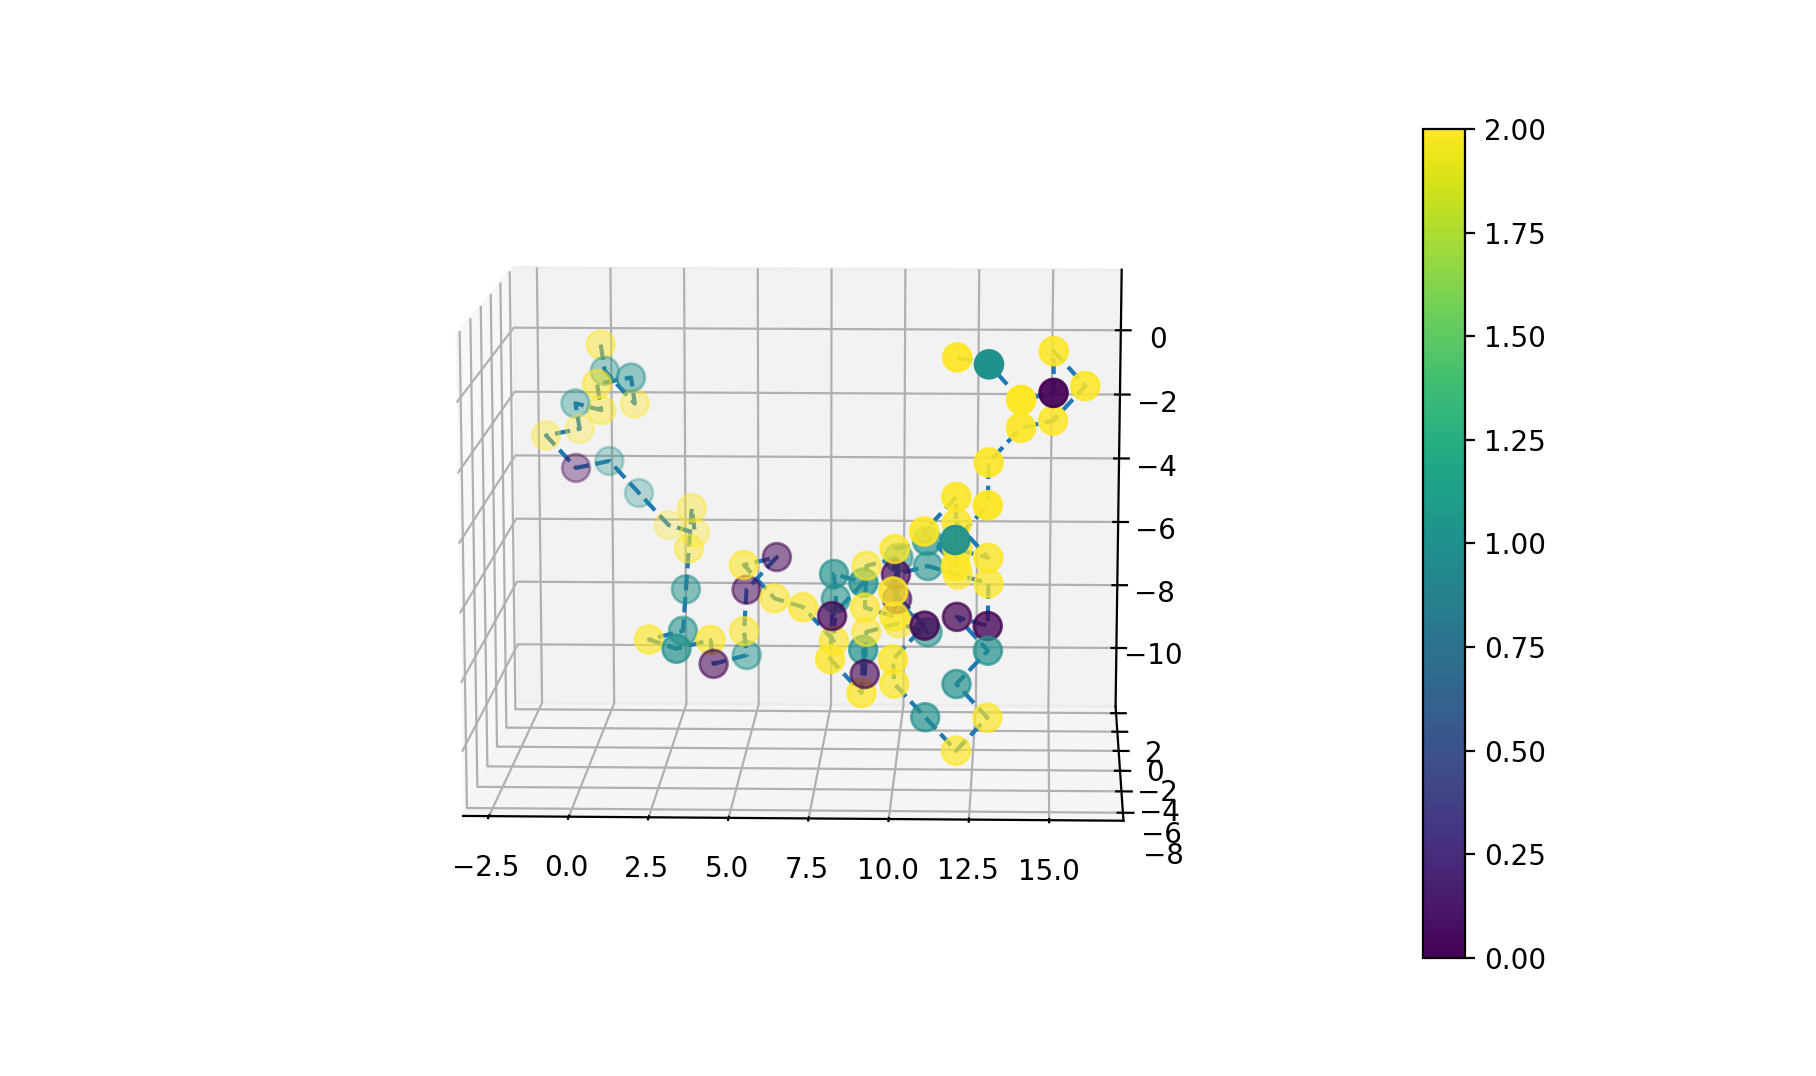

Energy: -18.050000000000004
Sequence: [2, 1, 2, 1, 2, 2, 1, 2, 2, 0, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2]


In [3]:
#display initial configuration
showme = True

seq = generateSequence(80,[0,1,2])
coords = generateChain(seq)
# Only one hydrogen bond per residue allowed
CanHBond = [True]*len(seq)
if(True):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    xdata = []
    ydata = []
    zdata = []
    for p in coords:
        x,y,z = [i for i in p]
        xdata.append(x)
        ydata.append(y)
        zdata.append(z)
    p = ax.scatter3D(xdata, ydata, zdata,s = 100,c = seq,cmap='viridis')
    ax.plot3D(xdata, ydata, zdata,'--')
    plt.colorbar(p)
    plt.show()

energy = getEnergy(coords,seq)
print(f'Energy: {energy}')
print(f'Sequence: {seq}')
#print(CanHBond)

In [4]:
TotalMoves = []
AcceptedMoves = []
MovePattern = []
Energy_list = []
Energy_list.append(energy)
Histogram = {}
lng = {}
Configuration_list = []
lnf = [1]
Snaps = []

while(lnf[0] > (1e-8)):
    makeMove(coords,seq,lnf,F_ENTER,Histogram,lng,Snaps)
print("Finished and converged!")    

#############################

Flatness ratio: 1.0
        Number of moves: 1000000
        Accepted moves: 6884
        Acceptance Ratio: 0.006884

Reseting the histogram.
            Current size: 739
            Min Energy -25.150000000000002
            Max Energy -15.874999999999996
            
Updated ln(f) to:  0.5
##########################


#############################

Flatness ratio: 0.9973297730307076
        Number of moves: 1100000
        Accepted moves: 7100
        Acceptance Ratio: 0.006454545454545454

Reseting the histogram.
            Current size: 749
            Min Energy -25.150000000000002
            Max Energy -15.874999999999996
            
Updated ln(f) to:  0.25
##########################


#############################

Flatness ratio: 0.9973404255319149
        Number of moves: 1200000
        Accepted moves: 7214
        Acceptance Ratio: 0.006011666666666667

Reseting the histogram.
            Current size: 752
            Min Energy -25.1500000

KeyboardInterrupt: 

## Summary

<IPython.core.display.Javascript object>


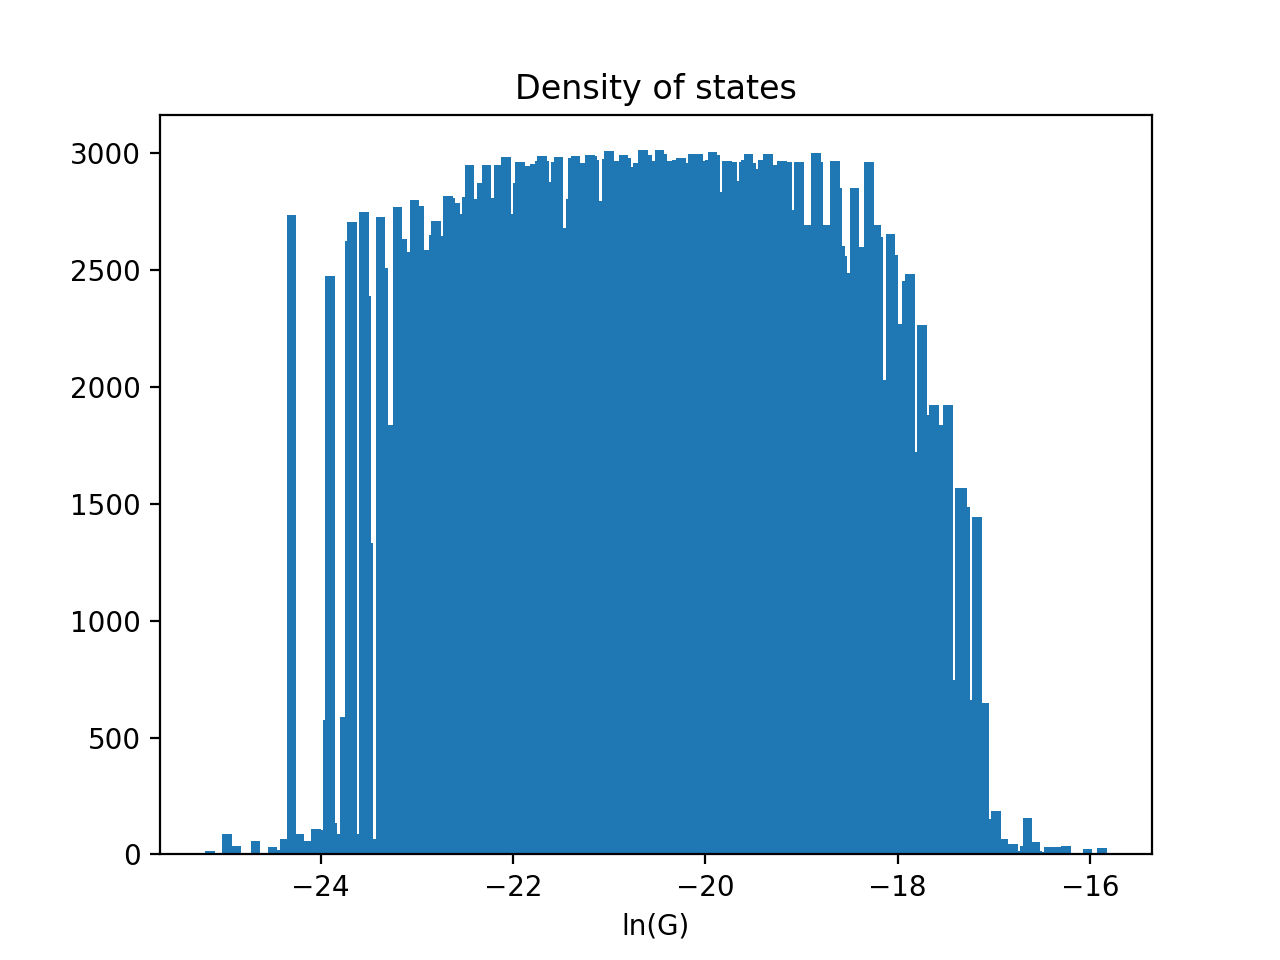

Minimum Energy: -25.150000000000002, degeneracy ln(G[0]): 14, minimum ln(G): 0.6875


In [5]:
ln_g = []
en = []
for k in sorted(lng.keys()):
    en.append(k)
    ln_g.append(lng[k])

plt.bar(en[:],ln_g[:],color='tab:blue',width = 0.1)
plt.xlabel("Energy bins")
plt.xlabel("ln(G)")
plt.title('Density of states')
plt.show()
print(f'Minimum Energy: {min(en)}, degeneracy ln(G[0]): {ln_g[0]}, minimum ln(G): {min(ln_g)}')

<IPython.core.display.Javascript object>


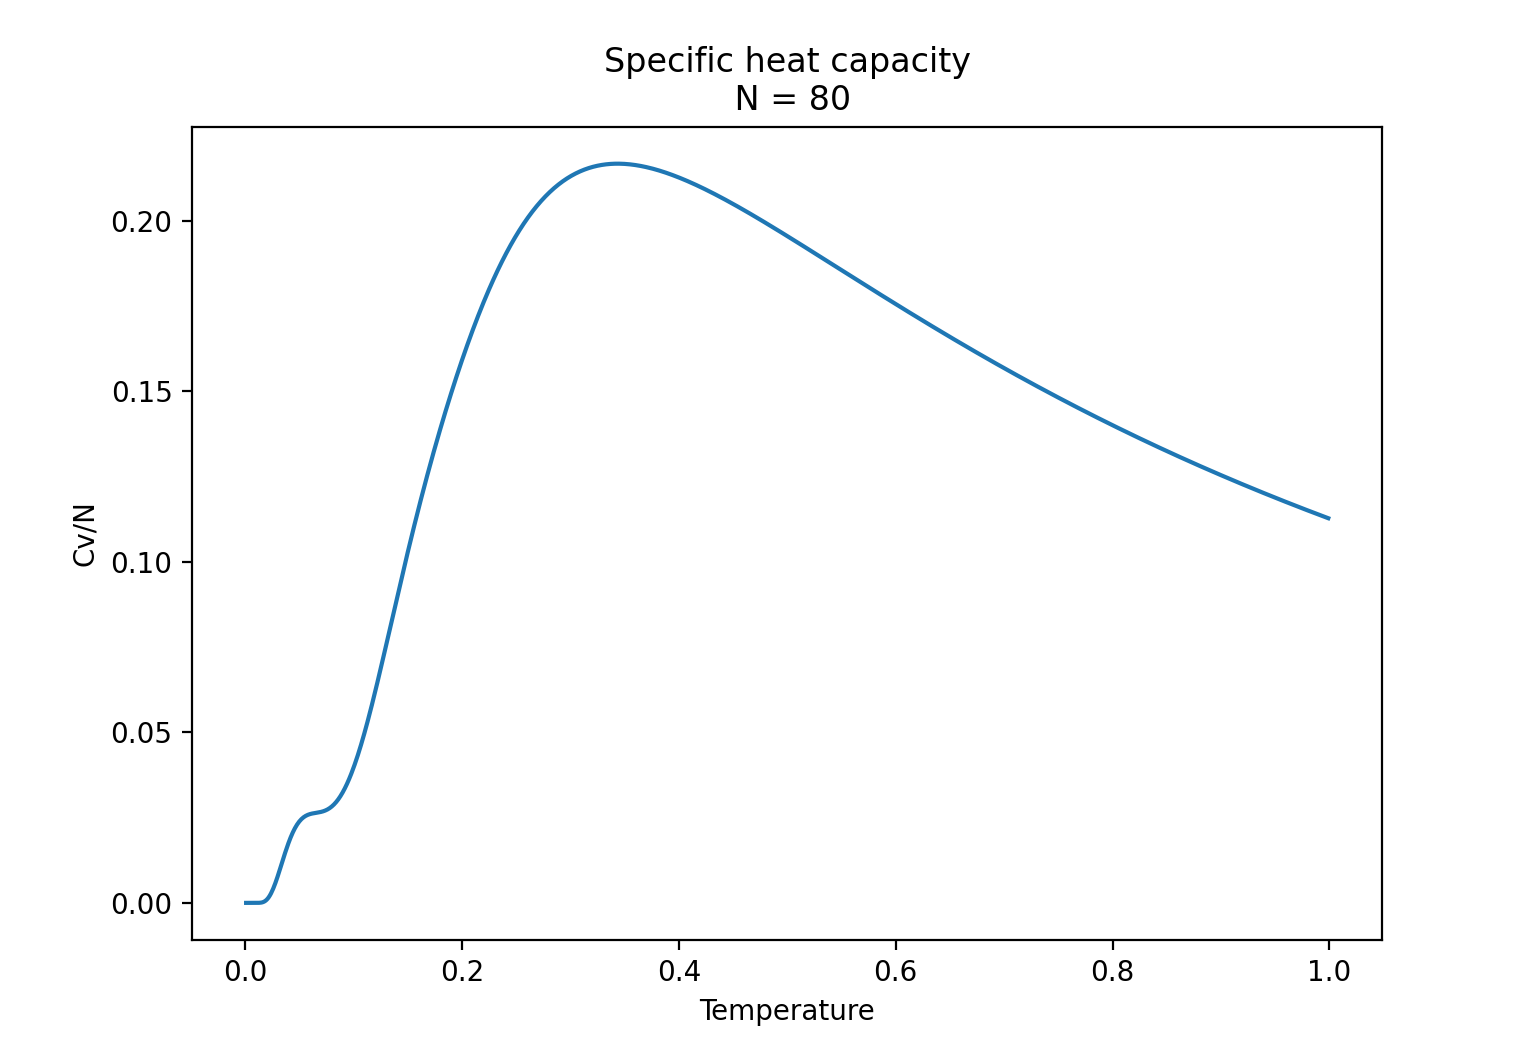

In [6]:
shift = abs(min(en))
en2 = []
for e in en:
    en2.append(e+shift)
temps = np.arange(0.001,1.0,0.001)
HC = []
Z = []
for T in temps:
    z = 0
    for n,e in enumerate(en2):
        z += ln_g[n]*np.exp(-e/T)
    Z.append(z)    

HC = []
for c,T in enumerate(temps):
    hc = 0
    for n,e in enumerate(en2):
        hc+=((((e**2)*np.exp(-e/T)*ln_g[n])/Z[c])- (((e*np.exp(-e/T)*ln_g[n])/Z[c])**2))
    HC.append(hc/T**2/len(seq))
plt.plot(temps,HC)
plt.xlabel("Temperature")
plt.ylabel("Cv/N")
plt.title(f'Specific heat capacity\n N = {len(seq)}')
plt.show()

In [ ]:
print(f'Finished with lnf = {lnf[0]}')
print(f'Total Moves:{len(TotalMoves)}, Accepted Moves:{len(AcceptedMoves)}, \
Ratio: {len(AcceptedMoves)/len(TotalMoves)*100} %')
energybins = []
values = []
for k in sorted(Histogram.keys()):
    energybins.append(k)
    values.append(Histogram[k])

count = 0
for i in values:
    if i > np.log(2)/lnf[0]:
        count +=1
print(f'Flatness ratio: {count/len(energybins)}\n')
plt.bar(energybins,values,width = 0.1,color = 'tab:red')
plt.xlabel("Energy bins")
plt.ylabel("Energy count")
plt.title('Histogram')
plt.show()  

<IPython.core.display.Javascript object>


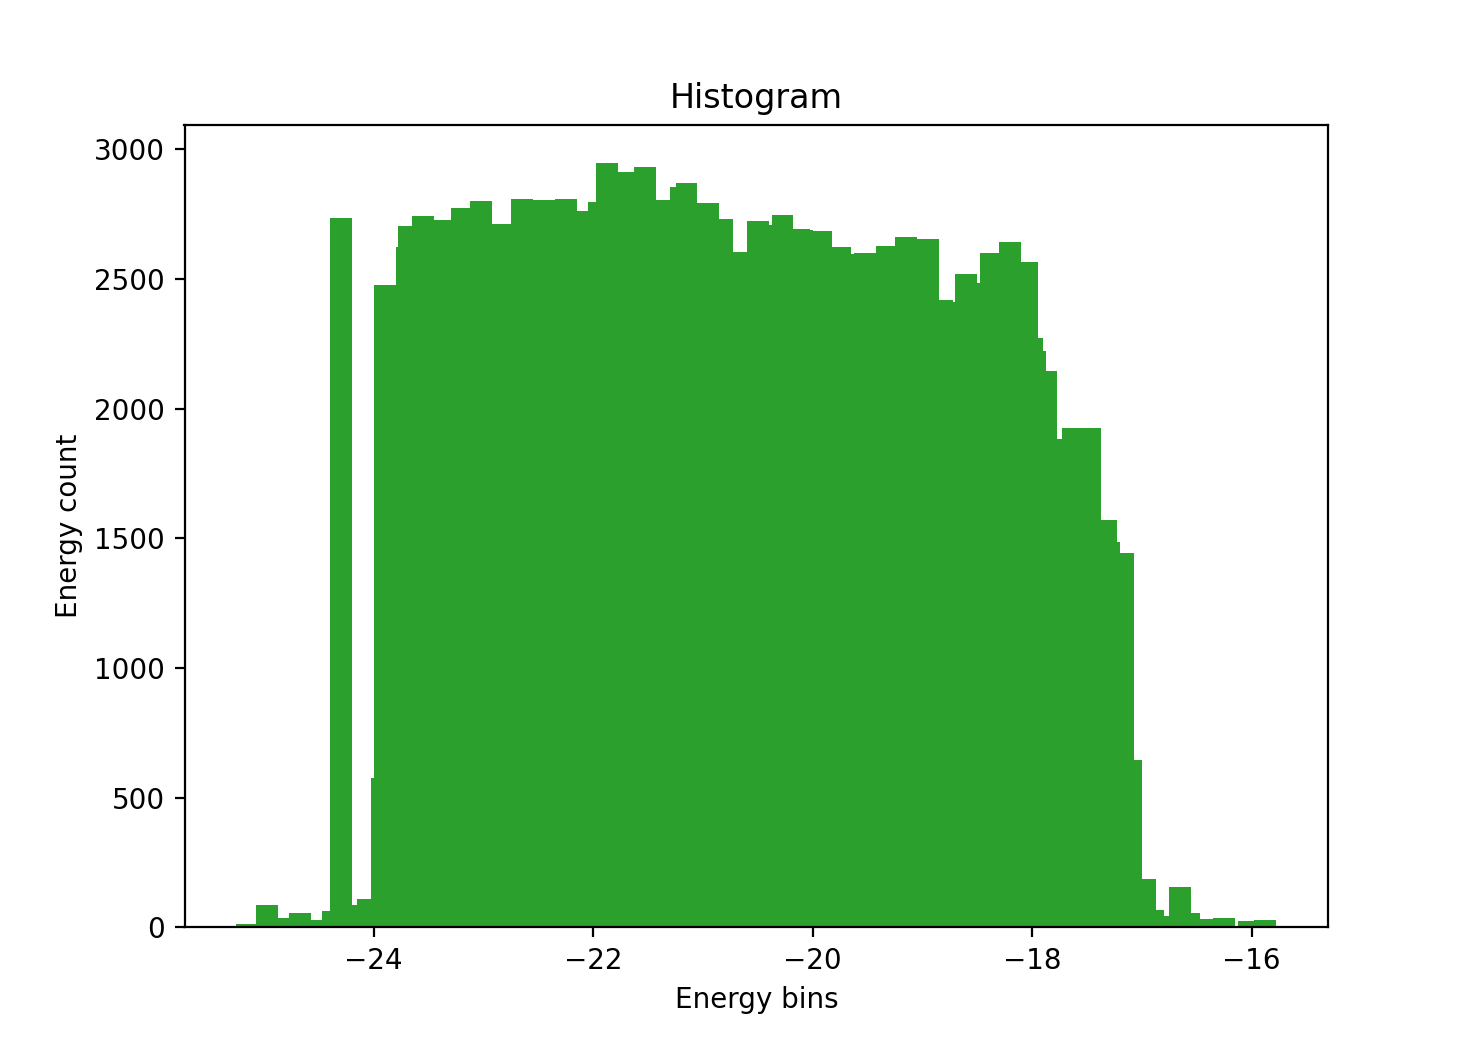

In [13]:
for ns in [0]:
    h1 = copy.deepcopy(Snaps[ns])
    values = []
    energybins = []
    for k in sorted(h1.keys()):
        energybins.append(k)
        values.append(h1[k])
    av = np.average(values)
    count = 0
    for i in values:
        if i < (av+np.std(values)) and i > (av-np.std(values)):
            count +=1
    #print(f'Flatness ratio (within average +/- std.(values)) for Snapshot {ns}: {count/len(energybins)}\n')  
    plt.bar(energybins,values,width = 0.2,color = 'tab:green')
    plt.xlabel("Energy bins")
    plt.ylabel("Energy count")
    plt.title('Histogram')
    plt.show()    

## Visited configurations

<IPython.core.display.Javascript object>


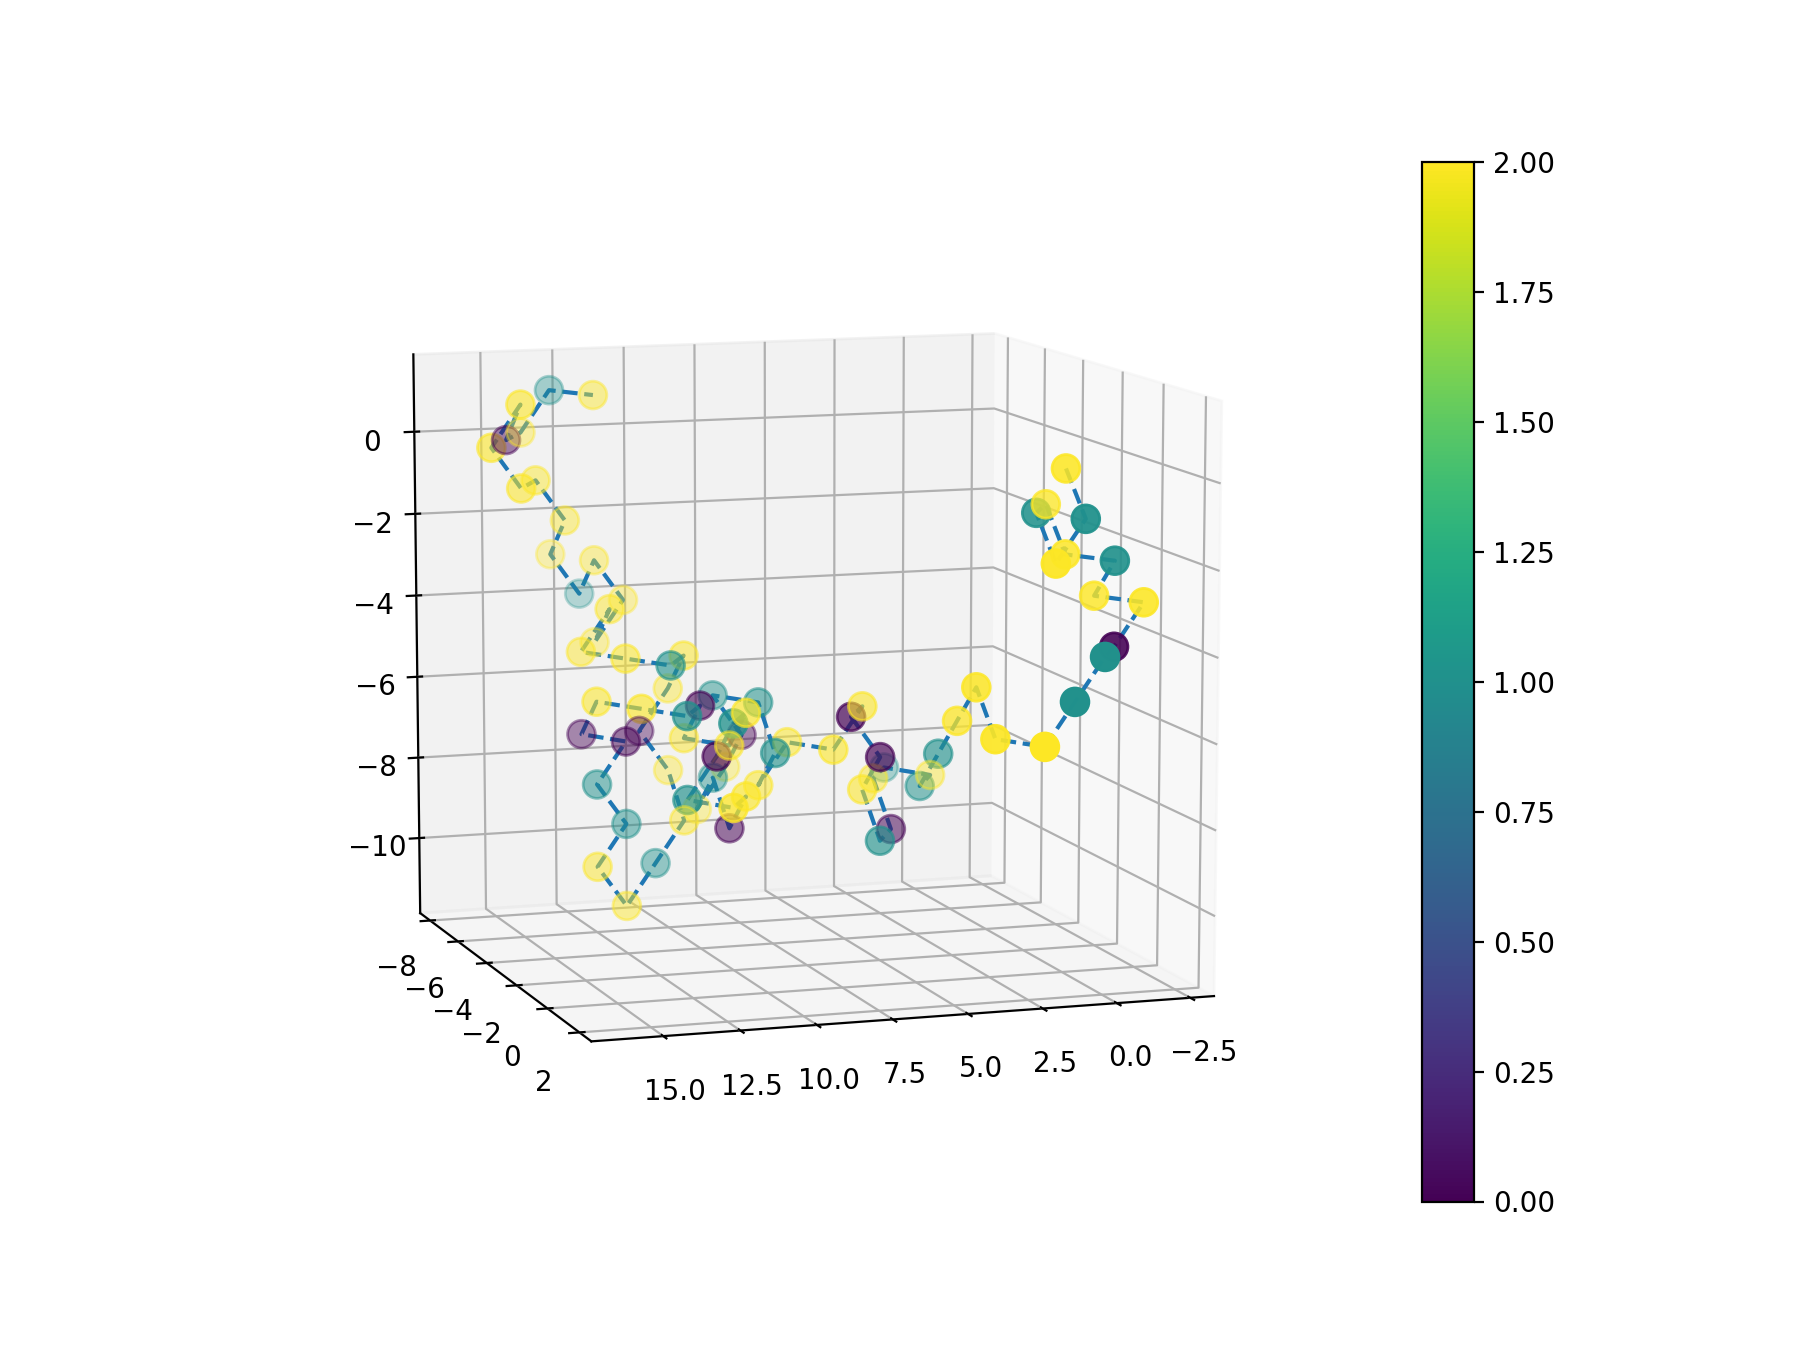

<IPython.core.display.Javascript object>


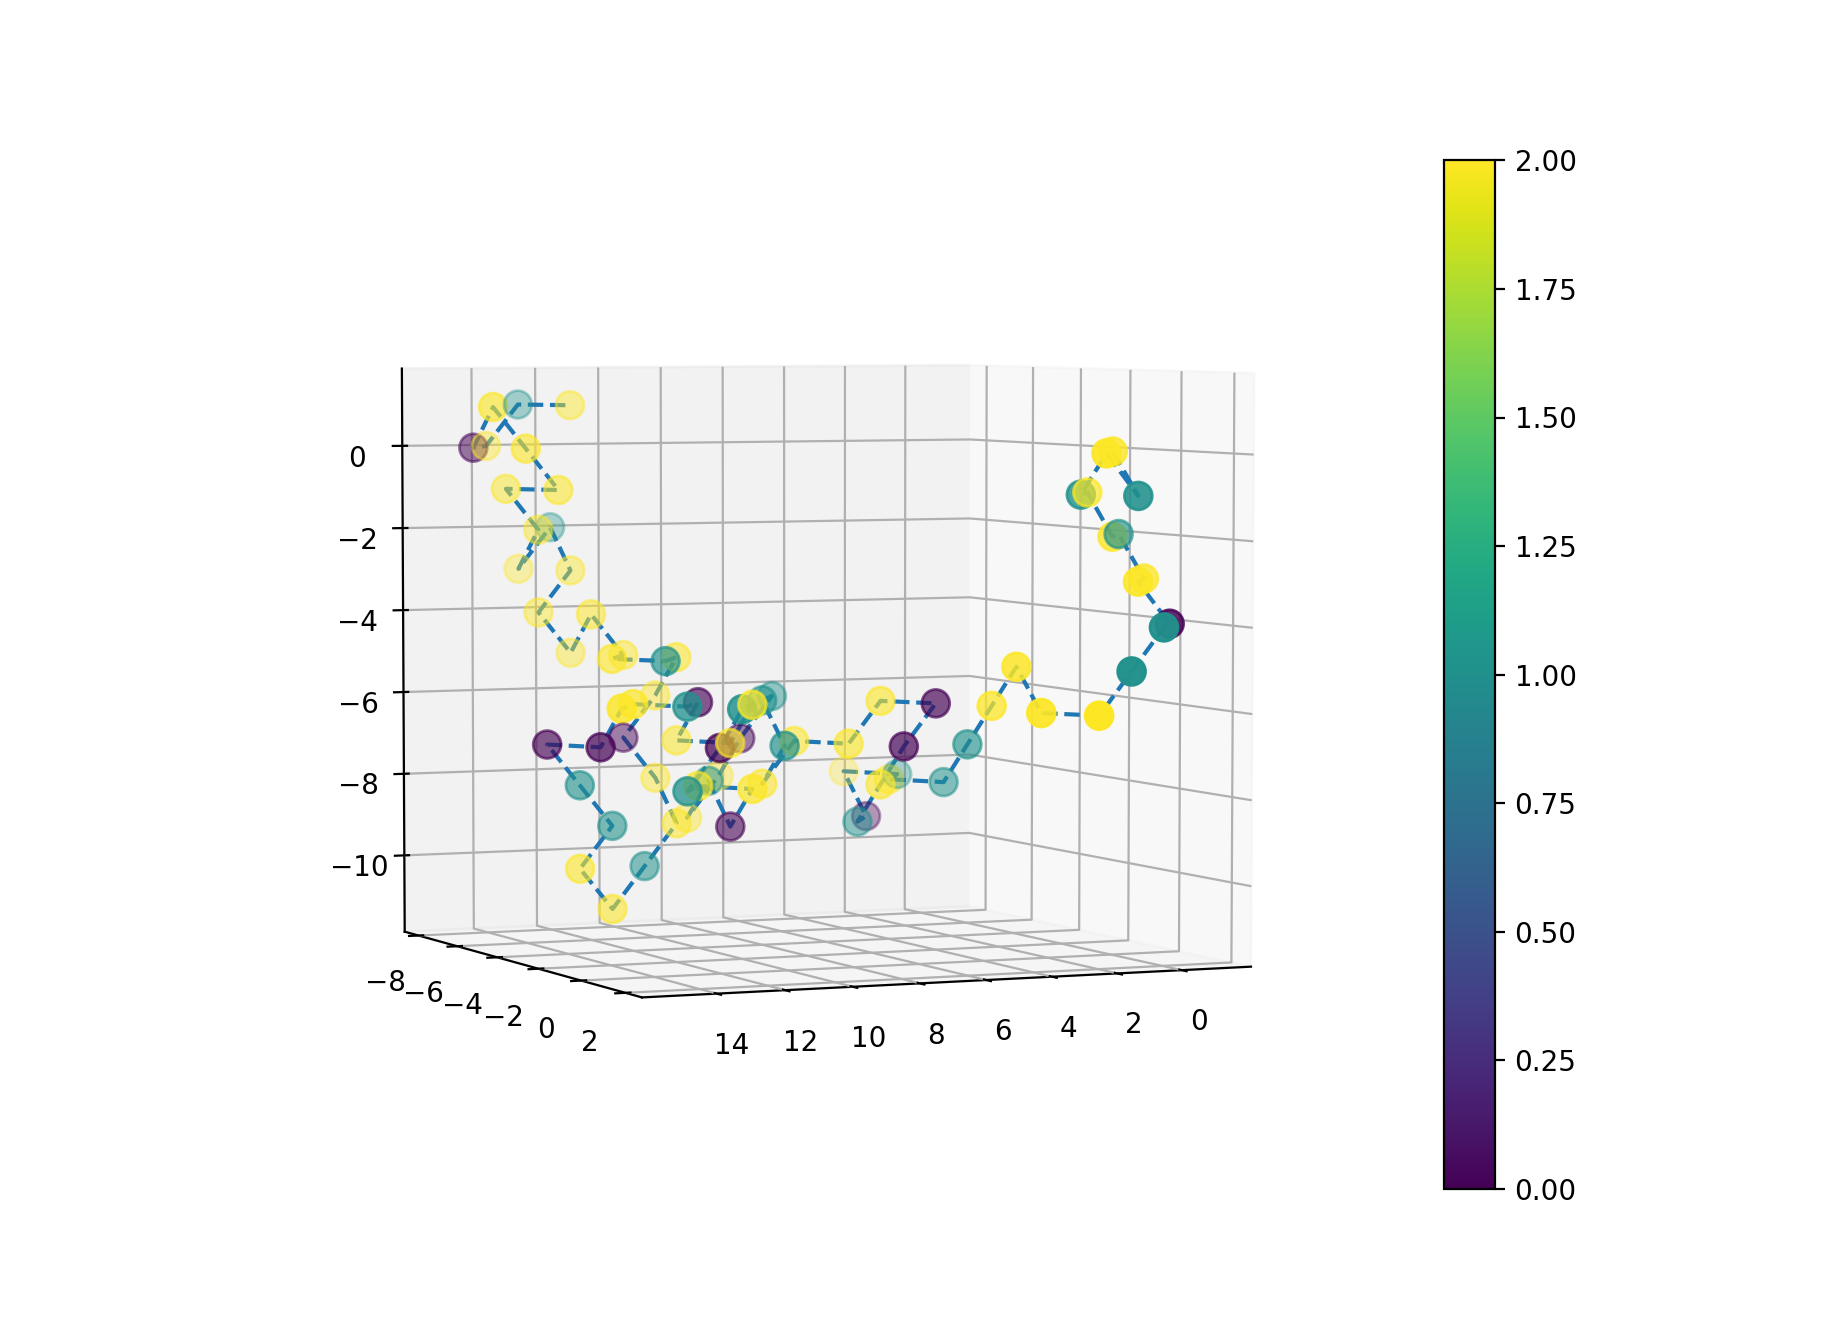

In [15]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = []
ydata = []
zdata = []

for p in Configuration_list[0]:
    x,y,z = [i for i in p]
    xdata.append(x)
    ydata.append(y)
    zdata.append(z)
p = ax.scatter3D(xdata, ydata, zdata,s = 100,c = seq,cmap='viridis')
ax.plot3D(xdata, ydata, zdata,'--')
plt.colorbar(p)
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
xdata = []
ydata = []
zdata = []
for p in Configuration_list[-1]:
    x,y,z = [i for i in p]
    xdata.append(x)
    ydata.append(y)
    zdata.append(z)
p = ax.scatter3D(xdata, ydata, zdata,s = 100,c = seq,cmap='viridis')
ax.plot3D(xdata, ydata, zdata,'--')
plt.colorbar(p)
plt.show()
plt.show()